# Spotify Graph Queries

We perform ten queries on our Spotify database relying on ***SPARQLWrapper***.

## Setup

We import all the necessary libraries and we set the URL needed by SPARQLWrapper

In [1]:
# Imports
import os
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt

from SPARQLWrapper import SPARQLWrapper, JSON
from IPython.display import display

In [2]:
SPOTIFY_ONTOLOGY = "https://www.dei.unipd.it/~martinelli/spotify/spotifyOntology#"
REPOSITORY_NAME = "Spotify2"
#REPOSITORY_NAME = "eu"

SPARQL_ENDPOINT = "http://localhost:7200/repositories/" + REPOSITORY_NAME

sparql = SPARQLWrapper(SPARQL_ENDPOINT)


## Query utilities
We define a function to perform a SPARQL query

In [3]:
# Execute a SPARQL query and return a DataFrame
def executeQuery(query, maxRows=None):
    global sparql

    # Set the number of rows and columns to display
    pd.set_option("display.max_rows", maxRows, "display.max_columns", None)

    # Set the query
    sparql.setQuery("""
            prefix so: <https://www.dei.unipd.it/~martinelli/spotify/spotifyOntology#>
            prefix countries: <http://eulersharp.sourceforge.net/2003/03swap/countries#>
            prefix xsd: <http://www.w3.org/2001/XMLSchema#>

            {query}
        """.format(query=query))

    # Set the result format
    sparql.setReturnFormat(JSON)

    # Execute the query
    try:
        results = sparql.query().convert()
    except:
        return None, None

    # If it is an ask
    if "boolean" in results.keys():
        return results["boolean"], "ask"
    
    # If it is a select
    if "results" in results.keys():
        # Create a DataFrame from the returned JSON
        resultDF = json_normalize(results["results"]["bindings"])

        # Remove the datadtypes columns
        resultDF = resultDF[[col for col in resultDF.columns if not col.endswith(
            ".type") and not col.endswith(".datatype")]]

        # Remove .value from column names
        resultDF = resultDF.rename(columns=lambda col: col.replace(".value", ""))

        # Remove the spotify ontology prefix from uris (to get only the ID)
        resultDF = resultDF.applymap(lambda x: str(x).replace(
            SPOTIFY_ONTOLOGY, "").replace("http://eulersharp.sourceforge.net/2003/03swap/countries#", ""))

        return resultDF, "select"
    
    return None, None


We define a function to print the result of a query

In [4]:
def printResult(result, resultType):
    if result is None:
        print("🛑 [[NO RESULTS]]\n")

    if resultType == "select":
        print("🗃️ [[RESULT]]\n")
        display(result)

    if resultType == "ask":
        print("🎱 [[ANSWER]]\n")
        print("✔️ Yes" if result else "❌ No")


## Plot utilities

In [5]:
TITLE_PAD = 30
TITLE_DIM = 30
XY_LABEL_PAD = 23
XY_LABEL_DIM = 21
XY_TICKS_DIM = 18
GRID_ALPHA = 0.2
FILL_ALPHA = 0.05
BAR_WIDTH = 0.95
LEGEND_LOC = "upper left"
COLOR_SCHEME = ["#1DB954", "#22577A", "#A03C78", "#C67ACE"]

FIG_SIZE = (18, 8)
FIG_BG_COLOR = "w"
FIG_DPI = 500
FIG_BBOX = "tight"
FIG_PAD = .3
FIG_FORMATS = ["png", "pdf"]


In [6]:
def plotResults(title=None, x=[], yArr=[],
                yLabel=None, xLabel=None, xTicks=None, ticksRotation=0, legend=None,
                bar=False, showGrid=False, gridAxis="both", fillPlot=False,
                figSize=FIG_SIZE, saveTitle=None):

    plt.figure(figsize=figSize, facecolor=FIG_BG_COLOR)

    maxY = None
    minY = None
    
    if not title is None:
        plt.title(title, fontsize=TITLE_DIM, pad=TITLE_PAD)
    
    numPlots = len(yArr)
    for i, y in zip(range(numPlots), yArr):
        label = None
        try:
            label = legend[i]
        except:
            pass
        
        yNum = [float(yVal) for yVal in y]
        maxY = np.max(
                        [np.max(yNum), maxY]
                    ) if not maxY is None else np.max(yNum)
        minY = np.min(
                        [np.min(yNum), minY]
        ) if not minY is None else np.min(yNum)

        if bar:
            barWidth = BAR_WIDTH / numPlots
            xOffset = -BAR_WIDTH / 2 + barWidth / 2 + barWidth * i
            plt.bar(x + xOffset, yNum, width=barWidth,
                    label=label, align="center", color=COLOR_SCHEME[i])
        else:
            plt.plot(x, yNum, label=label, color=COLOR_SCHEME[i])

            if fillPlot:
                plt.fill_between(x, yNum, alpha=FILL_ALPHA,
                                 facecolor=COLOR_SCHEME[i])
    
    if not xLabel is None:
        plt.xlabel(xLabel, labelpad=XY_LABEL_PAD, fontsize=XY_LABEL_DIM)

    if not yLabel is None:
        plt.ylabel(yLabel, labelpad=XY_LABEL_PAD, fontsize=XY_LABEL_DIM)

    if not xTicks is None:
        plt.xticks(x, xTicks, fontsize=XY_TICKS_DIM, rotation=ticksRotation)
        
    yPad = (maxY - minY) * 0.1
    topLim = maxY + yPad * 2
    infLim = minY - yPad if bar else minY - yPad
    infLim = 0 if bar and minY >= 0 and minY <= yPad else infLim
    plt.ylim(top=topLim, bottom=infLim)

    plt.yticks(fontsize=XY_TICKS_DIM)

    if showGrid:
        plt.grid(alpha=GRID_ALPHA, axis=gridAxis)

    if not legend is None:
        plt.legend(loc=LEGEND_LOC)
    
    if not saveTitle is None:
        baseDir = "plots"
        if not os.path.exists(baseDir):
            os.mkdir("plots")

        for figFormat in FIG_FORMATS:
            saveDir = baseDir + "/" + figFormat
            if not os.path.exists(saveDir):
                os.mkdir(saveDir)

            plt.savefig(saveDir + "/" + saveTitle + "." + figFormat,
                        facecolor=FIG_BG_COLOR,
                        dpi=FIG_DPI,
                        bbox_inches=FIG_BBOX,
                        pad_inches=FIG_PAD)

    plt.show()


## Queries

### Query 1
On average how many artist of a specific nationality are in the top 100 of the same country?

🗃️ [[RESULT]]



,country,avgNumArtists
0,cr,1
1,ec,1
2,sg,1
3,ch,1
4,pe,2
5,at,2
6,nz,2
7,cl,2
8,pt,3
9,my,3


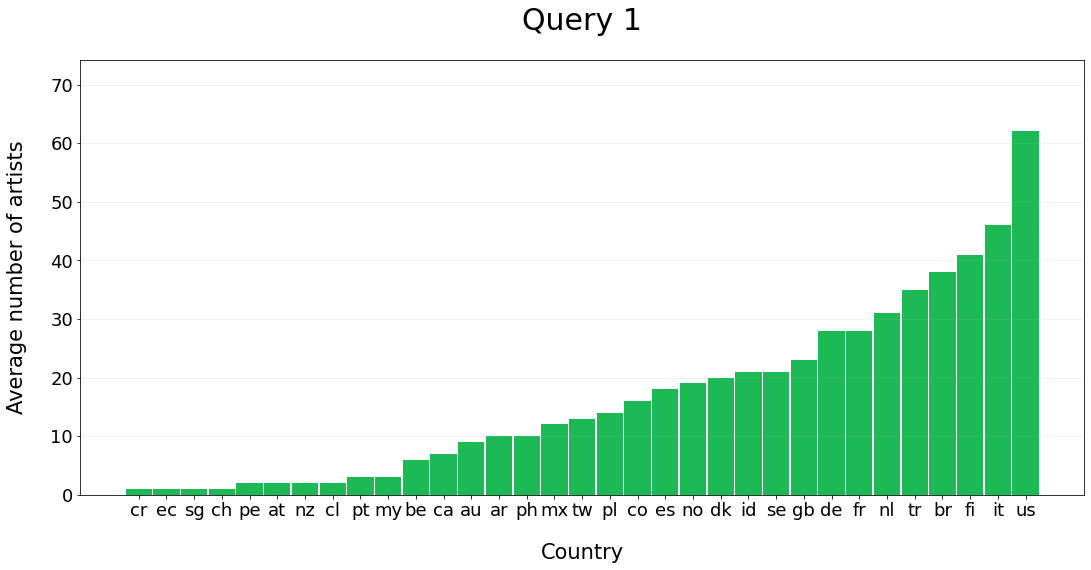

In [7]:
result, resultType = executeQuery("""
	select ?country (xsd:integer(AVG(?numArtists)) AS ?avgNumArtists) where {
		{
			select ?date ?country (count(distinct ?artist) AS ?numArtists) where {
				?person 		so:isMemberOf ?artist ;
								so:hasNationality ?country.
				?artist 		so:partecipateIn ?track ;
								so:name ?name.
				?track 			so:appearsIn ?appeareance .
				?appeareance 	so:isPositionedIn ?chart .
				?chart 			so:isReferredTo ?country ;
								so:date ?date .   
			}
			group by ?date ?country
		}
	}
	group by ?country
	order by ?avgNumArtists
""")

printResult(result, resultType)

if not result is None:
	plotResults(
		title="Query 1",
		x=np.arange(len(result)),
		yArr=[result["avgNumArtists"]],
		yLabel="Average number of artists",
		xLabel="Country",
		xTicks=result["country"],
		showGrid=True,
		gridAxis="y",
		bar=True,
		saveTitle="query1"
	)


### Query 2
Show the 20 most popular young (less than 30 years) italian artist who published in 2018

🗃️ [[RESULT]]



,artistName,artistAvgAge,artistPopularity
0,Måneskin,21,88
1,Sfera Ebbasta,29,81
2,Rkomi,27,76
3,Capo Plaza,23,75
4,Ultimo,25,75
5,tha Supreme,20,74
6,Rocco Hunt,27,72
7,Ernia,28,72
8,Lazza,27,70
9,Tedua,27,70


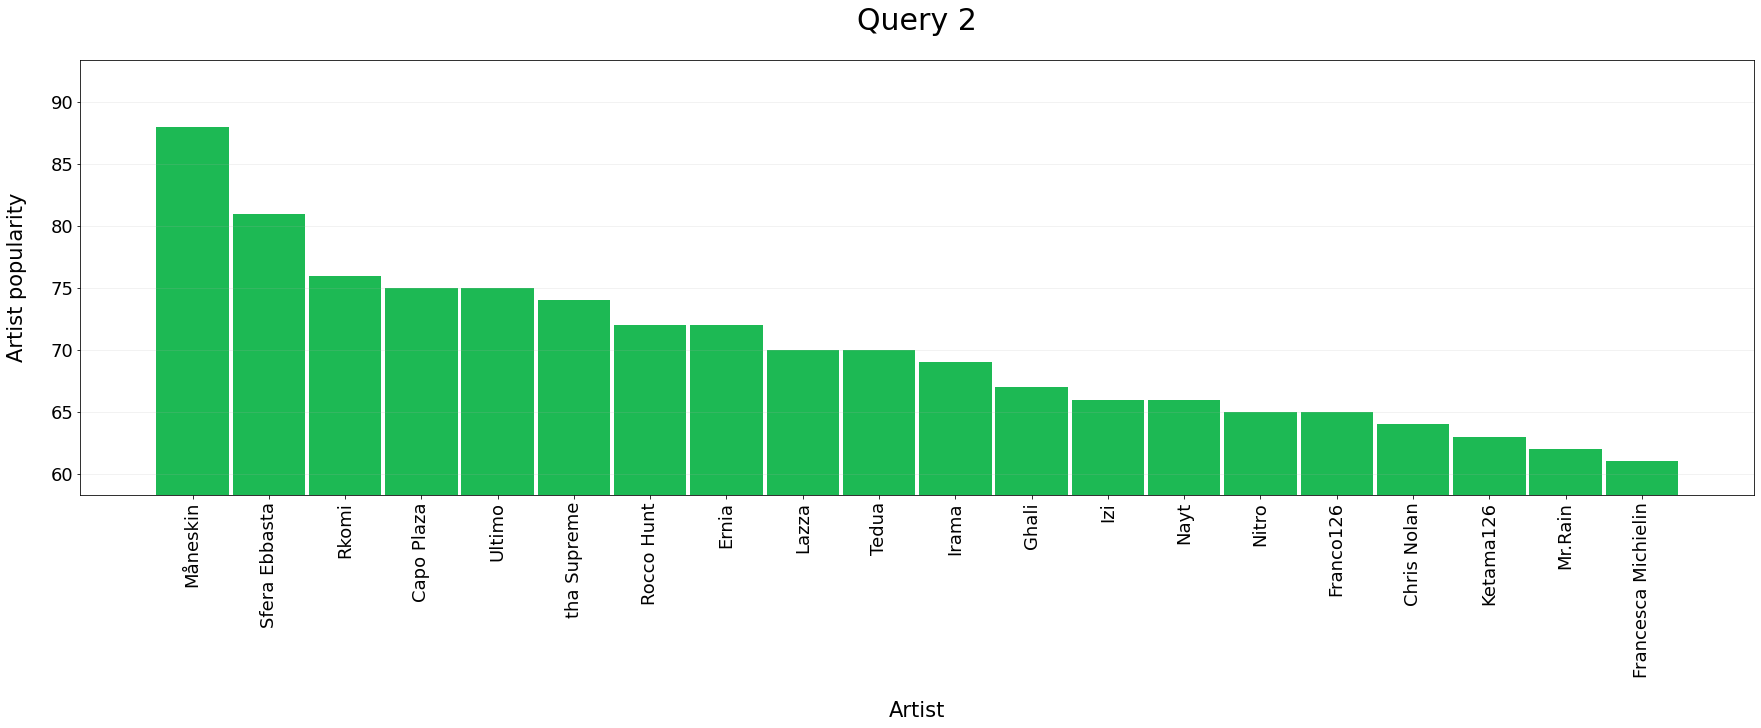

In [8]:
result, resultType = executeQuery("""
select distinct ?artistName (avg(?artistAge) as ?artistAvgAge) ?artistPopularity where {
    ?person so:isMemberOf ?artist ;
            so:hasNationality countries:it ;
            so:birthDate ?artistBirthdate .
    ?artist so:partecipateIn ?track ;
            so:name ?artistName ;
    		so:popularity ?artistPopularity .
    ?track so:isPartOf ?album ;
           so:name ?trackName .
	?album so:releaseDate ?releaseDate ;
        	so:name ?albumName .
    filter(?releaseDate >= "2018-01-01"^^xsd:date && ?releaseDate < "2019-01-01"^^xsd:date) .
    filter(?artistBirthdate >= "1991-01-01"^^xsd:date ) .
    bind((year(now()) - year(?artistBirthdate)) as ?artistAge)
} group by ?artistName ?artistPopularity
order by desc(?artistPopularity)
limit 20
""")

printResult(result, resultType)

if not result is None:
    plotResults(
        figSize=(30, 8),
        title="Query 2",
        x=np.arange(len(result)),
        yArr=[result["artistPopularity"]],
        yLabel="Artist popularity",
        xLabel="Artist",
        xTicks=result["artistName"],
        ticksRotation=90,
        showGrid=True,
        gridAxis="y",
        bar=True,
        saveTitle="query2"
    )


### Query 3
Show the 30 genres with most danceable songs relative to songs released in 2019

🗃️ [[RESULT]]



,genre,avgDanceability,numTrack
0,atl-hip-hop,0.79661226,116
1,argentine-hip-hop,0.7831876,144
2,southern-hip-hop,0.7698771,138
3,trap,0.76905227,360
4,trap-argentino,0.768414,198
5,swedish-trap,0.7683592,206
6,swedish-gangsta-rap,0.76725316,229
7,rap-francais,0.76190495,443
8,swedish-drill,0.76131296,131
9,reggaeton-flow,0.7612071,251


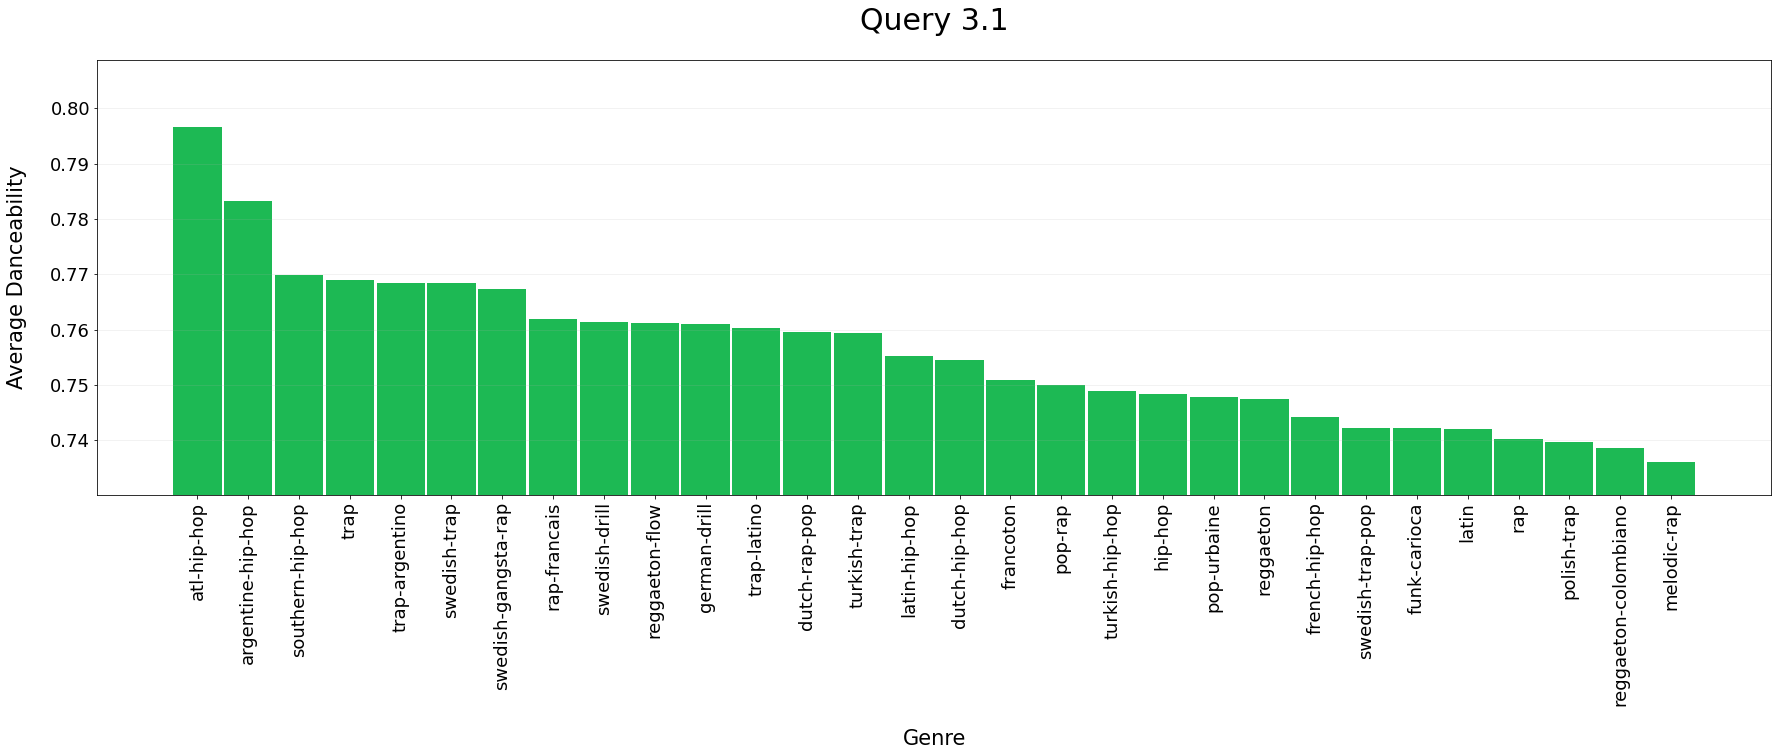

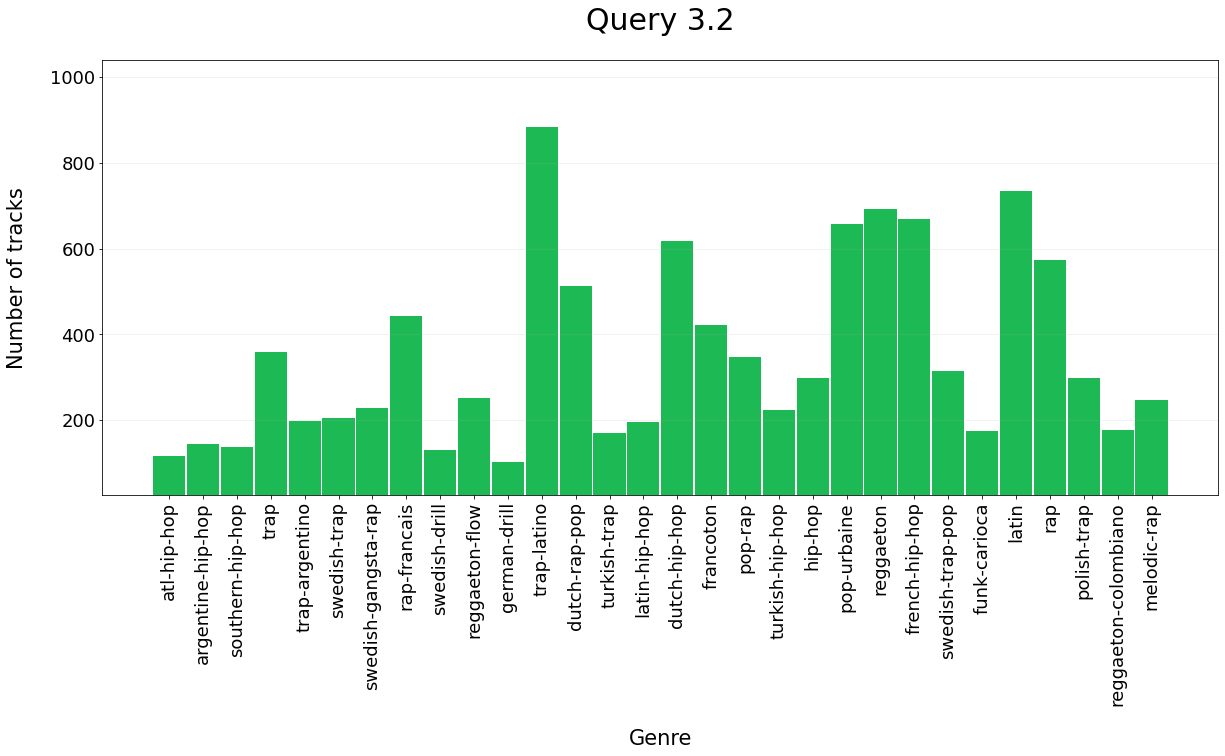

In [9]:
result, resultType = executeQuery("""
    select ?genre (avg(?danceability) as ?avgDanceability) (count(?track) as ?numTrack) where {
        ?artist so:partecipateIn ?track ;
                so:name ?artistName ;
                so:hasGenre ?genre .
        ?track 	so:isPartOf ?album ;
                so:name ?trackName ;
                so:danceability ?danceability .
        ?album 	so:releaseDate ?date ;
                so:name ?albumName .
        filter(?date >= "2019-01-01"^^xsd:date && ?date < "2020-01-01"^^xsd:date)
    }
    group by ?genre
    having (?numTrack > 100)
    order by desc(?avgDanceability)
    limit 30
""")

printResult(result, resultType)

if not result is None:
    plotResults(
        figSize=(30, 8),
        title="Query 3.1",
        x=np.arange(len(result)),
        yArr=[result["avgDanceability"]],
        xLabel="Genre",
        yLabel="Average Danceability",
        xTicks=result["genre"],
        ticksRotation=90,
        showGrid=True,
        gridAxis="y",
        bar=True,
        saveTitle="query3.1"
    )

    plotResults(
        figSize=(20, 8),
        title="Query 3.2",
        x=np.arange(len(result)),
        yArr=[result["numTrack"]],
        xLabel="Genre",
        yLabel="Number of tracks",
        xTicks=result["genre"],
        ticksRotation=90,
        showGrid=True,
        gridAxis="y",
        bar=True,
        saveTitle="query3.2"
    )


### Query 4
In 2019 there was more distinct singles in top 100 Argentina or top 100 Italy?

In [10]:
result, resultType = executeQuery("""
ask where{
    {
        select (count(distinct ?track) as ?numSinglesAG) where {
            ?track so:isPartOf ?album ;
             	   so:name ?trackName ;
    			   so:appearsIn ?appearance .
        	?album so:isTypeOf so:single;
                	so:name ?albumName .	
        	?appearance so:isPositionedIn ?chart .
        	?chart so:isReferredTo countries:ar ;
                   so:date ?date .
    		filter(?date >= "2018-01-01"^^xsd:date && ?date < "2019-01-01"^^xsd:date)
		}
    } .
    {
        select (count(distinct ?track) as ?numSinglesIT) where {
            ?track so:isPartOf ?album ;
             	   so:name ?trackName ;
    			   so:appearsIn ?appearance .
        	?album so:isTypeOf so:single;
                	so:name ?albumName .	
        	?appearance so:isPositionedIn ?chart .
        	?chart so:isReferredTo countries:it ;
                   so:date ?date .
    		filter((?date >= "2018-01-01"^^xsd:date && ?date < "2019-01-01"^^xsd:date))
		}
    } .
    
    filter(?numSinglesAG > ?numSinglesIT)
}
""")

printResult(result, resultType)


🎱 [[ANSWER]]

✔️ Yes


### Query5
How many times tracks made by an artist born after 2000 were present in top 100 Italy in 2020?

In [11]:
result, resultType = executeQuery("""
    select distinct ?trackName ?artistName ?completeName ?birthDate (count(?chartDate) as ?numAppearances) where { 
        ?track a so:Track ;
            so:name ?trackName ;
            so:appearsIn ?appearance .
        ?artist a so:Artist ;
                so:partecipateIn ?track ;
                so:name ?artistName .
        ?artistPerson so:isMemberOf ?artist ;
                    so:name ?realName ;
                    so:surname ?realSurname ;
                    so:birthDate ?birthDate ;
                    so:deathDate ?deathDate .
        ?appearance a so:Appearance ;
                    so:isPositionedIn ?chart.
        ?chart a so:Chart;
            so:isReferredTo countries:it ;
            so:date ?chartDate ;
            so:name ?chartName .

        bind(concat(?realName, " ", ?realSurname) AS ?completeName) .
        filter(?birthDate >= "2000-01-01"^^xsd:date) .
        filter(?chartDate > "2020-01-01"^^xsd:date) .
    } group by ?trackName ?artistName ?completeName ?birthDate
    order by desc(?numAppearances)
""")

printResult(result, resultType)


🗃️ [[RESULT]]



,trackName,artistName,completeName,birthDate,numAppearances
0,blun7 a swishland,tha Supreme,Davide Mattei,2001-03-17,44
1,Cin Cin,Yanomi,Andrea De Filippi,2000-08-22,38
2,Roses - Imanbek Remix,Imanbek,Imanbek,2000-10-21,37
3,Dance Monkey,Tones And I,Toni Watson,2000-08-13,32
4,fuck 3x,tha Supreme,Davide Mattei,2001-03-17,30
5,Nena (feat. Geolier & Andry The Hitmaker),Geolier,Geolier,2000-03-23,28
6,SUPREME - L'ego (feat. tha Supreme & Sfera Ebb...,tha Supreme,Davide Mattei,2001-03-17,28
7,"TesTa TrA Le NuVoLE, pT. 2 – prod. Yanomi",Yanomi,Andrea De Filippi,2000-08-22,24
8,death bed (coffee for your head),beabadoobee,Beatrice Kristi Laus,2000-06-03,24
9,M' Manc (con Geolier & Sfera Ebbasta),Geolier,Geolier,2000-03-23,21


### Query 6
Show average of different features of tracks through the months of the year in Italy

🗃️ [[RESULT]]



,month,avgEnergy,avgDanceability,avgValence
0,1,0.676324,0.6773355,0.4858008
1,2,0.6698627,0.66868484,0.46911755
2,3,0.6661872,0.6813587,0.4766929
3,4,0.6724947,0.6887026,0.4881666
4,5,0.6735469,0.6968381,0.50205266
5,6,0.6937827,0.715239,0.53640735
6,7,0.6970845,0.7168283,0.5438225
7,8,0.69762576,0.7173735,0.54736763
8,9,0.6839285,0.71198446,0.520966
9,10,0.68324304,0.702946,0.509811


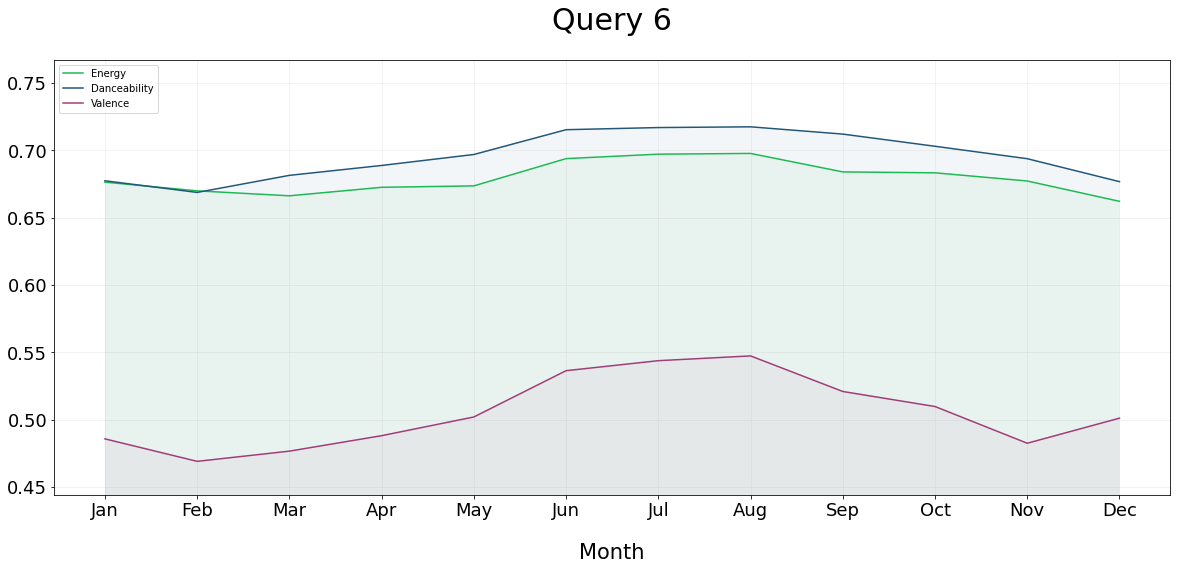

In [12]:
result, resultType = executeQuery("""
       select ?country ?month
              (avg(?energy) as ?avgEnergy)
              (avg(?danceability) as ?avgDanceability)
              (avg(?valence) as ?avgValence)
       where {
              ?track a so:Track ;
                     so:appearsIn ?appearance ;
                     so:danceability ?danceability ;
                     so:energy ?energy ;
                     so:valence ?valence .
              ?appearance so:isPositionedIn ?chart ;
                            so:position ?position .
              ?chart so:date ?date ;
                     so:isReferredTo countries:it .

              bind(month(?date) as ?month)
       } group by ?month ?country
       order by asc(?country) asc(?month) 
""")

printResult(result, resultType)

if not result is None:
       plotResults(
       figSize=(20, 8),
       title="Query 6",
       x=np.arange(len(result)),
       yArr=[result["avgEnergy"], result["avgDanceability"], result["avgValence"]],
       xLabel="Month",
       xTicks=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
       legend=["Energy", "Danceability", "Valence"],
       showGrid=True,
       fillPlot=True,
       saveTitle="query6"
       )


### Query 7
How many albums (at least 2) contains the same track?

In [13]:
result, resultType = executeQuery("""
    select ?trackNameWithArtists (group_concat(distinct ?albumName; separator=", ") as ?albums) (count(distinct ?album) as ?albumCount) where {
        {
            select ?track ?trackName ?albumType ?album ?albumName (group_concat(?artistName; separator=", ") as ?artists) where {
                ?track a so:Track ;
                    so:name ?trackName ;
                    so:isPartOf ?album .
                ?album so:isTypeOf ?albumType ;
                    so:name ?albumName .
                ?artist so:partecipateIn ?track ;
                        so:name ?artistName .
            } group by ?track ?trackName ?albumType ?album ?albumName
        } .

        bind(concat(?trackName, " (", ?artists, ")") as ?trackNameWithArtists) .
    } group by ?trackNameWithArtists
    having (count(distinct ?album) > 1)
    order by desc(?albumCount)
    limit 30
""")

printResult(result, resultType)

🗃️ [[RESULT]]



,trackNameWithArtists,albums,albumCount
0,"Boogieman (feat. Salmo) (Ghali, Salmo)","DNA, Boogieman (feat. Salmo)",6
1,Believer (Imagine Dragons),"Evolve, Believer",6
2,Thunder (Imagine Dragons),"Evolve, Thunder",6
3,Feelings (Lauv),"~how i'm feeling~, Feelings",6
4,"i'm so tired... (Troye Sivan, Lauv)","~how i'm feeling~, i'm so tired...",6
5,Verloren (Tabitha),Beste Zangers Seizoen 2020 (Tabitha),5
6,Good Times (Ghali),DNA,5
7,Whatever It Takes (Imagine Dragons),"Evolve, Whatever It Takes",5
8,Sunflower - Spider-Man: Into the Spider-Verse ...,"Hollywood's Bleeding, Sunflower (Spider-Man: I...",5
9,My Only Wish (This Year) (Britney Spears),"Pop & Wave - Christmas Edition, Five Songs Of ...",5


### Query 8
Show how many explicit tracks appears in the top 100 for each country

🗃️ [[RESULT]]



,country,numExplicitTracks
0,vg,1103
1,us,1694
2,tw,358
3,tr,404
4,sg,428
5,se,900
6,pt,661
7,pl,674
8,ph,311
9,pe,236


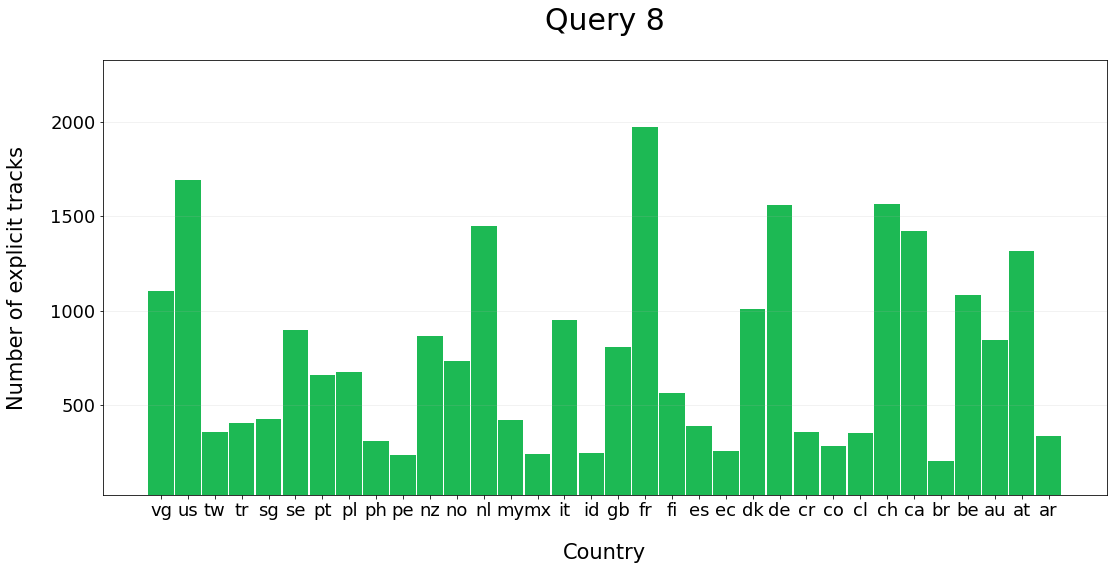

In [14]:
result, resultType = executeQuery("""
    select ?country (count(distinct ?track) as ?numExplicitTracks) where {
        ?track so:appearsIn ?appearance ;
            so:explicit ?explicit .
        ?appearance so:isPositionedIn ?chart ;
                    so:position ?position .
        ?chart so:isReferredTo ?country .
        
        filter(?explicit = "true"^^xsd:boolean) .
    } group by ?country
    order by desc(?country)
""")

printResult(result, resultType)

if not result is None:
	plotResults(
		title="Query 8",
		x=np.arange(len(result)),
		yArr=[result["numExplicitTracks"]],
		yLabel="Number of explicit tracks",
		xLabel="Country",
		xTicks=result["country"],
		showGrid=True,
		gridAxis="y",
		bar=True,
		saveTitle="query11"
	)


### Query 9
How many songs of artists from Japan or South Korea reaches Top 20 in US, Canada or Mexico?

In [15]:
result, resultType = executeQuery("""
        select ?chartCountry (count(distinct ?track) as ?numTracks) where {
                ?person so:isMemberOf ?artist ;
                        so:hasNationality ?originCountry .
                ?artist so:partecipateIn ?track .
                ?track so:appearsIn ?appeareance .
                ?appeareance so:isPositionedIn ?chart ;
                                so:position ?position .
                ?chart so:isReferredTo ?chartCountry .

                filter(?originCountry = countries:jp || ?originCountry = countries:kr) .
                filter(?chartCountry = countries:us || ?chartCountry = countries:mx || ?chartCountry = countries:ca) .
                filter(?position <= 20) .
        } group by ?chartCountry
        order by desc(?numTracks)
""")

printResult(result, resultType)


🗃️ [[RESULT]]



,chartCountry,numTracks
0,ca,9
1,us,7


Show also the names of the tracks

In [18]:
result, resultType = executeQuery("""
select DISTINCT ?trackName (group_concat(distinct ?artistName; separator=", ") as ?artists) where {
                ?person so:isMemberOf ?artist ;
                        so:hasNationality ?originCountry .
                ?artist so:partecipateIn ?track ;
    					so:name ?artistName .
                ?track so:appearsIn ?appeareance ;
            			so:name ?trackName .
                ?appeareance so:isPositionedIn ?chart ;
                                so:position ?position .
                ?chart so:isReferredTo ?chartCountry .

                filter(?originCountry = countries:jp || ?originCountry = countries:kr) .
                filter(?chartCountry = countries:us || ?chartCountry = countries:mx || ?chartCountry = countries:ca) .
                filter(?position <= 20) .
        }
GROUP BY ?trackName
""")

printResult(result, resultType)

🗃️ [[RESULT]]



,trackName,artists
0,Run,Joji
1,Happy Xmas (War Is Over) - Remastered 2010,"Yoko Ono, The Plastic Ono Band"
2,Dynamite,BTS
3,Boy With Luv (feat. Halsey),BTS
4,Sour Candy (with BLACKPINK),BLACKPINK
5,Ice Cream (with Selena Gomez),BLACKPINK
6,How You Like That,BLACKPINK
7,Old Town Road (feat. RM of BTS) - Seoul Town R...,"BTS, RM"
8,Lovesick Girls,BLACKPINK


### Query 10
Show the 30 albums with the most high number of songs present in Top 30 at the same time. Show also how many tracks are contained in the album

In [16]:
result, resultType = executeQuery("""
    select ?chartName ?chartDate ?albumName ?numTracks ?totalTracks where {
        ?chart so:name ?chartName ;
            so:date ?chartDate .
        ?album so:name ?albumName ;
            so:totalTracks ?totalTracks .
        {
            select ?chart ?album (count(distinct ?track) as ?numTracks) where {
                ?track so:isPartOf ?album ;
                    so:appearsIn ?appereance .
                ?appereance so:isPositionedIn ?chart ;
                            so:position ?position .
                filter(?position <= 30)
            } group by ?chart ?album
            order by desc(?numTracks)
            limit 30
        }
    }
""")

printResult(result, resultType)


🗃️ [[RESULT]]



,chartName,chartDate,albumName,numTracks,totalTracks
0,TOP 100 USA,2018-07-01,Scorpion,23,25
1,TOP 100 Canada,2018-07-01,Scorpion,22,25
2,TOP 100 Canada,2017-03-19,More Life,21,22
3,TOP 100 USA,2017-03-19,More Life,21,22
4,TOP 100 Italy,2019-11-17,23 6451,20,20
5,TOP 100 Chile,2020-03-01,YHLQMDLG,20,20
6,TOP 100 Chile,2020-03-08,YHLQMDLG,19,20
7,TOP 100 France,2019-09-08,Mr Sal,18,18
8,TOP 100 France,2019-03-24,Destin,18,18
9,TOP 100 France,2019-03-31,Destin,18,18


### Query 11
The most listened artist and his nationality for each country

In [17]:
result, resultType = executeQuery("""
    select ?country ?artistName (group_concat(distinct ?nationality; separator=", ") as ?nationalities) where {
        ?artist so:name ?artistName .
        ?person so:isMemberOf ?artist ;
                so:hasNationality ?nationality .
        {
            select ?country_ (max(?numTracks) as ?maxNumTracks) where {
                {
                    select ?country_ ?artist (count(?track) as ?numTracks) where {
                        ?person so:isMemberOf ?artist ;
                                so:hasNationality ?nationality .
                        ?artist so:partecipateIn ?track ;
                                so:name ?artistName .
                        ?track so:appearsIn ?appearance .
                        ?appearance so:isPositionedIn ?chart .
                        ?chart so:isReferredTo ?country_ .
                    } group by ?country_ ?artist
                }
            } group by ?country_
        } .
        {
            select ?country ?artist (count(?track) as ?numTracks) where {
                ?person so:isMemberOf ?artist ;
                        so:hasNationality ?nationality .
                ?artist so:partecipateIn ?track ;
                        so:name ?artistName .
                ?track so:appearsIn ?appearance .
                ?appearance so:isPositionedIn ?chart .
                ?chart so:isReferredTo ?country .
            } group by ?country ?artist
        } .
        
        filter(?numTracks = ?maxNumTracks)
    } group by ?country ?artistName
    order by asc(?country)
""")

printResult(result, resultType)


🗃️ [[RESULT]]



,country,artistName,nationalities
0,ar,Ozuna,pr
1,at,Capital Bra,de
2,au,Maroon 5,us
3,au,Post Malone,us
4,be,TOTO,"us, za, gb"
5,br,Matheus & Kauan,br
6,ca,Drake,ca
7,ch,Imagine Dragons,us
8,cl,Bad Bunny,pr
9,cl,CNCO,"us, ec, ca, pr, cu"
